In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2

In [2]:
# Parameter setzen
n_participants = 500
years = 10
effect_of_sex = 0.0
effect_of_age = -0.2

# random effects
var_intercept = 2
var_slope = 0.1

# fixed effects
weights = {'Systolic_BP': -0.1, 'Diastolic_BP': -0.1, 'Cholesterol': -0.2, 'Triglycerides': -0.2, 'BMI': -0.4, 'Creatinin': -0.1}


def simulate_data(num_participants):
    data = []
    # simulate data for each patient 
    for participant_id in range(1, n_participants + 1):
        age = np.random.randint(30, 61)  # patients are between 30 and 60
        gender = np.random.choice([0, 1])
        group = np.random.choice([0, 1])
        baseline_bp_sys = np.random.normal(120, 10)  # normal distributed systolic blood pressure vals
        baseline_bp_dia = np.random.normal(80, 10)  # normal ditributed diastolic blood pressure vals
        baseline_cholesterol = np.random.normal(200, 30)  # Cholesterin in mg/dL
        baseline_triglycerides = np.random.normal(150, 20)  # Triglyceride in mg/dL
        baseline_creatinin = np.random.normal(1,0.2) #creatinin in mg/dL
        baseline_bmi = np.random.normal(25, 4)  # BMI
        years_after_treatment = 0

        # randomly determine when the patient gets treatment 
        get_treatment = np.zeros((years), dtype=int)
        start_points = np.random.randint(3, years)
        for _ in range(years):
            get_treatment[start_points:] = 1

        # simulate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, np.sqrt(var_slope))
        
        # simulate data for each year
        for year in range(years):
            # effect of the treatment
            if get_treatment[year] == 1:
                delta_bp = -2 * year  # treatment issues improvement of data  
                delta_cholesterol = -5 * year  # Cholesterin reduction of treatment
                delta_triglycerides = -3 * year  # Triglyceride reduction of treatment
                delta_creatinin = -0.08 * year
                years_after_treatment += 1
            else:
                delta_bp = -0.5 * year  # minimal natural improvement
                delta_cholesterol = -1 * year
                delta_triglycerides = -1 * year
                delta_creatinin = -0.01 * year
            
            # calculate the scores for each year
            sys_bp = baseline_bp_sys + delta_bp + np.random.normal(0, 5)
            dia_bp = baseline_bp_dia + delta_bp + np.random.normal(0, 5)
            cholesterol = max(100, baseline_cholesterol + delta_cholesterol + np.random.normal(0, 10))
            triglycerides = max(50, baseline_triglycerides + delta_triglycerides + np.random.normal(0, 5))
            creatinin = max(0.6, baseline_creatinin + delta_creatinin + np.random.normal(0, 0.1))

            bmi = baseline_bmi + np.random.normal(0, 0.5)  
            
            # calculate the test score 
            health_score = (150 + random_intercept +
                        weights['Systolic_BP'] * sys_bp +
                        weights['Diastolic_BP'] * dia_bp +
                        weights['Cholesterol'] * cholesterol +
                        weights['Triglycerides'] * triglycerides +
                        weights['BMI'] * bmi + 
                        weights['Creatinin'] * creatinin +
                        effect_of_sex * gender + 
                        effect_of_age * age +
                        random_slope * year)
            
            yearly_data = {
                'patient_id': participant_id,
                'Year': year,
                'Age': age,
                'Group': group,
                'Gender': gender,
                'Get_treatment': get_treatment[year] ,
                'Years_after_treatment' : years_after_treatment,
                'Systolic_BP': sys_bp,
                'Diastolic_BP': dia_bp,
                'Cholesterol': cholesterol,
                'Creatinin' : creatinin, 
                'Triglycerides': triglycerides,
                'BMI': bmi,
                'Health_Score': health_score
            }
            
            data.append(yearly_data)
            age += 1
    return data

# Erstelle einen DataFrame aus den gesammelten Daten
df = pd.DataFrame(simulate_data(n_participants))
data = simulate_data(n_participants)

In [3]:
df

,patient_id,Year,Age,Group,Gender,Get_treatment,Years_after_treatment,Systolic_BP,Diastolic_BP,Cholesterol,Creatinin,Triglycerides,BMI,Health_Score
0,1,0,59,1,0,0,0,144.977808,69.191884,261.108873,1.111366,118.665783,21.570131,32.180777
1,1,1,60,1,0,0,0,151.661714,76.972261,239.663599,1.227984,123.436928,21.994245,33.537158
2,1,2,61,1,0,0,0,140.628778,74.681879,258.641659,1.356619,122.140431,22.152361,30.906360
3,1,3,62,1,0,0,0,146.554205,81.900409,251.949971,1.154073,121.448618,22.588172,30.563886
4,1,4,63,1,0,0,0,143.036066,77.681913,244.940692,1.205319,118.363222,22.609354,32.992179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,500,5,58,0,1,0,0,117.772524,107.025375,236.536137,1.014246,114.132081,18.328447,38.937687
4996,500,6,59,0,1,0,0,117.857507,92.947395,240.501084,0.752768,114.205727,20.084013,38.581544
4997,500,7,60,0,1,0,0,109.038310,104.172434,237.985994,0.707351,110.887385,19.370273,39.526038
4998,500,8,61,0,1,1,1,91.311633,81.865636,220.423509,0.600000,92.907748,19.886611,50.170365


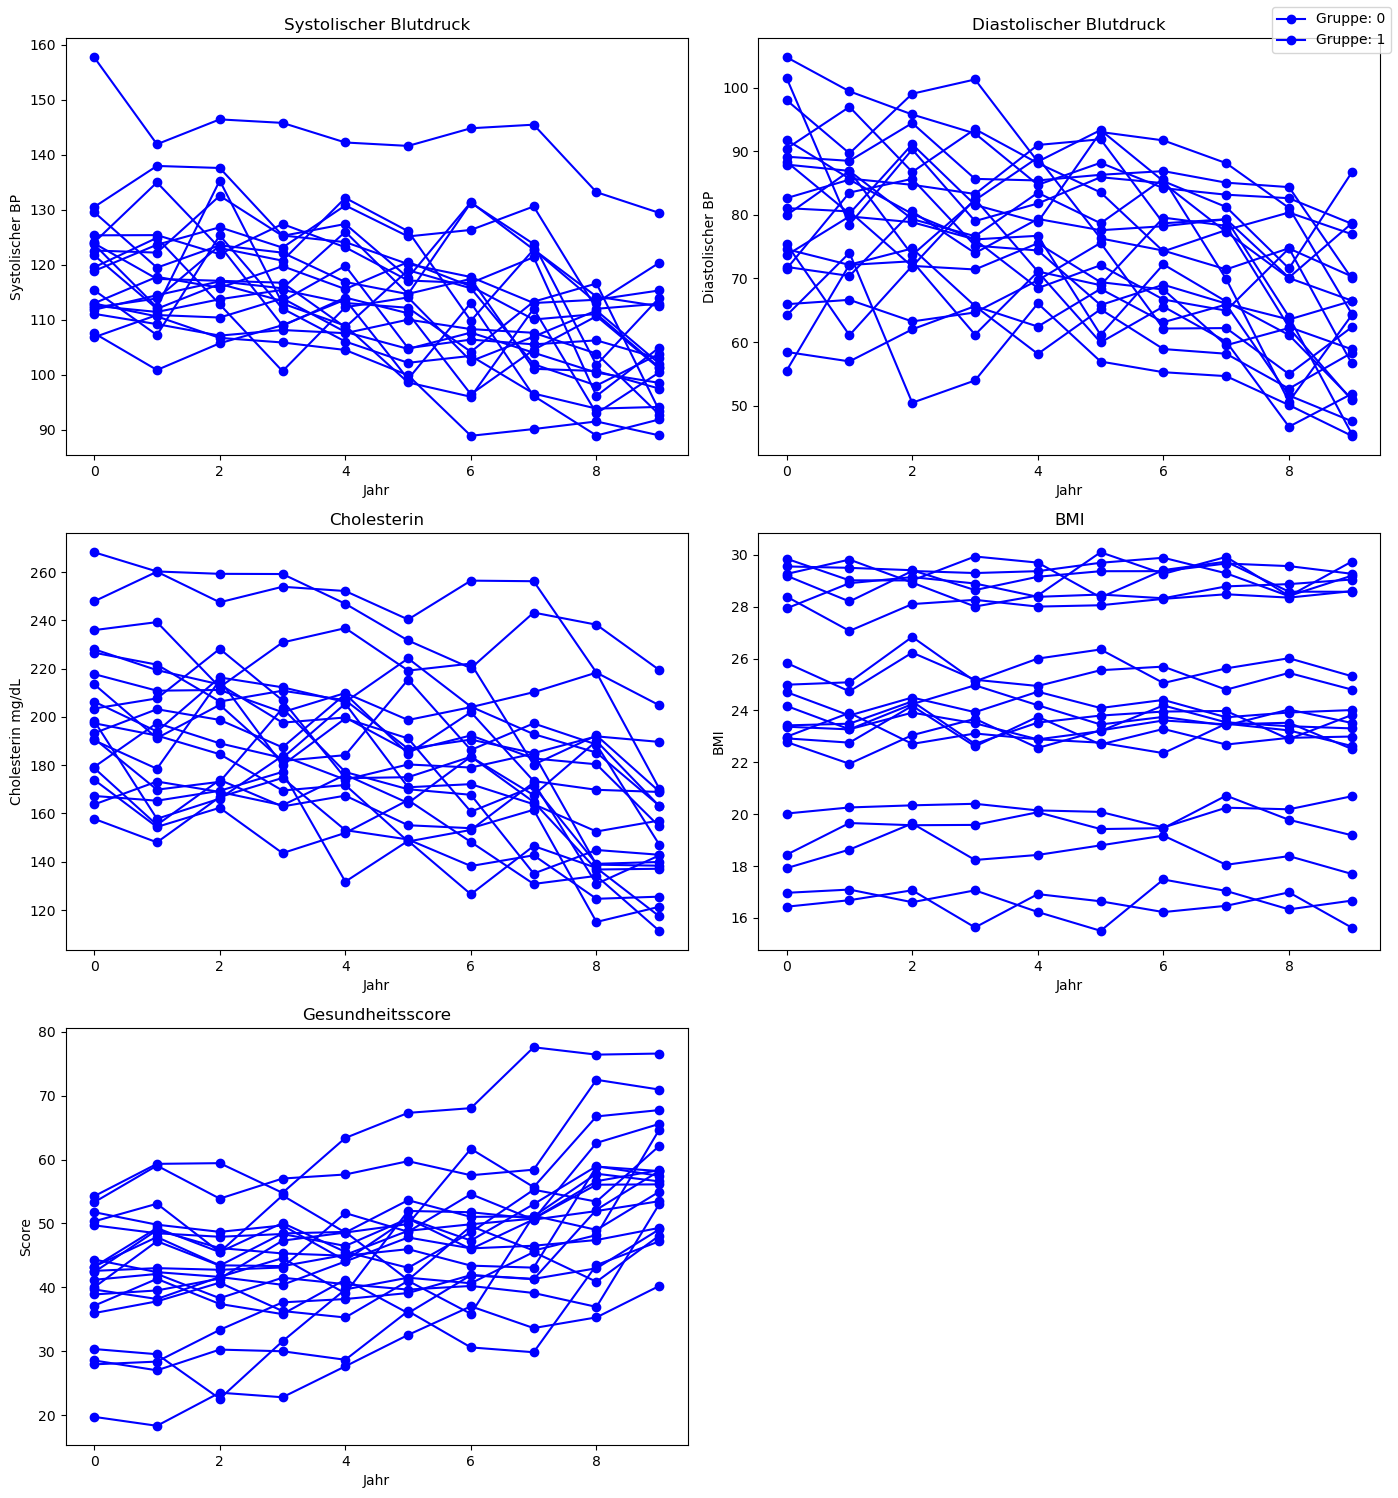

In [14]:
# choose 20 random patients
random_participants = np.random.choice(df['patient_id'].unique(), 5, replace=False)

# create plots for the chosen patients
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 plot

# Farben für die Gruppen definieren
colors = {'Intervention': 'blue', 'Control': 'red'}

# Boolean flags to add legend only once
legend_added = {
    'Pre-Treatment': False,
    'Post-Treatment': False
}

# Plotte für jede Metrik und füge nur einmal die Legende für jede Gruppe hinzu
for participant in random_participants:
    subset = df[df['patient_id'] == participant]
    treatment_switch = subset[subset['Get_treatment'].diff() == 1].index
    group = subset['Group'].iloc[0]

    if not treatment_switch.empty:
        switch_point = treatment_switch[0] -1
        if not legend_added['Pre-Treatment']:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red", label='Pre-Treatment')
            legend_added['Pre-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Systolic_BP'], marker='o', color="red")

        if not legend_added['Post-Treatment']:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green", label='Post-Treatment')
            legend_added['Post-Treatment'] = True
        else:
            ax[0, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Systolic_BP'], marker='o', color="green")

        ax[0, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Diastolic_BP'], marker='o', color="red")
        ax[0, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Diastolic_BP'], marker='o', color="green")
        ax[1, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Cholesterol'], marker='o', color="red")
        ax[1, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Cholesterol'], marker='o', color="green")
        ax[1, 1].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'BMI'], marker='o', color="blue")
        ax[1, 1].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset.loc[:switch_point, 'Year'], subset.loc[:switch_point, 'Health_Score'], marker='o', color="red")
        ax[2, 0].plot(subset.loc[switch_point:, 'Year'], subset.loc[switch_point:, 'Health_Score'], marker='o', color="green")
    else:
        ax[0, 0].plot(subset['Year'], subset['Systolic_BP'], marker='o', color="blue")
        ax[0, 1].plot(subset['Year'], subset['Diastolic_BP'], marker='o', color="blue")
        ax[1, 0].plot(subset['Year'], subset['Cholesterol'], marker='o', color="blue")
        ax[1, 1].plot(subset['Year'], subset['BMI'], marker='o', color="blue")
        ax[2, 0].plot(subset['Year'], subset['Health_Score'], marker='o', color="blue")


# set labels and titles
ax[0, 0].set_title('Systolischer Blutdruck')
ax[0, 0].set_xlabel('Jahr')
ax[0, 0].set_ylabel('Systolischer BP')
ax[0, 1].set_title('Diastolischer Blutdruck')
ax[0, 1].set_xlabel('Jahr')
ax[0, 1].set_ylabel('Diastolischer BP')
ax[1, 0].set_title('Cholesterin')
ax[1, 0].set_xlabel('Jahr')
ax[1, 0].set_ylabel('Cholesterin mg/dL')
ax[1, 1].set_title('BMI')
ax[1, 1].set_xlabel('Jahr')
ax[1, 1].set_ylabel('BMI')
ax[2, 0].set_title('Gesundheitsscore')
ax[2, 0].set_xlabel('Jahr')
ax[2, 0].set_ylabel('Score')

# Add legend once
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax):
    return  2 * (Lmax - Lmin)

In [17]:
num_simulations = 100
lrt_results = []
#keys for random and fixed effects in the matrix
fixed_effects_keys_full= ['Age', 'Gender', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI', 'Creatinin', 'Get_treatment']
random_effects_keys_full = ['Years_after_treatment']
#keys for random and fixed effects in the matrix
fixed_effects_keys_red = ['Age', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI','Creatinin', 'Get_treatment']
random_effects_keys_red = ['Years_after_treatment']

n_fixed_eff_full = len(fixed_effects_keys_full) + 1
n_rand_eff_full = len(random_effects_keys_full) + 1
n_fixed_eff_red = len(fixed_effects_keys_red) + 1
n_rand_eff_red = len(random_effects_keys_red) + 1
softplus = torch.nn.Softplus()

for sim in range(num_simulations):
    print(f"Epoch: {sim}")
    print("\nTrain full model")
    data = pd.DataFrame(simulate_data(200))
    N = len(df)

    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_full = calculate_Zlist(df, random_effects_keys_full)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_full = calculate_Xlist(df, fixed_effects_keys_full)

    # Response variable: Test scores
    y_full = torch.from_numpy(np.array(df['Health_Score'])).to(torch.float32)

    # Learnable parameter for diagonal covariance matrix
    D_param_full = torch.randn(n_rand_eff_full, requires_grad=True)


    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_full = [torch.cat((X_i, torch.zeros((n_rand_eff_full, n_fixed_eff_full)))) for X_i in X_list_full]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_full = torch.cat([torch.cat((y_full[get_ind(pat, df)], torch.zeros(n_rand_eff_full))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_full): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_full))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_full]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_full)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_full
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_full - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_full].detach().item(), 3)}, "+ \
            ", ".join([f"est. {fixed_effects_keys_full[i]}: {round(pred[-n_fixed_eff_full+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_full))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_full = minimize(calculate_likelihood, D_param_full, method='bfgs', max_iter=6)
    loglikelihood_full = result_full.fun

    print("\nTrain reduced model")
    # Random effects design matrix (Datenmatrix) for each patient
    Z_list_red = calculate_Zlist(df, random_effects_keys_red)

    # Fixed effects design matrix (Datenmatrix) for each patient
    X_list_red = calculate_Xlist(df, fixed_effects_keys_red)

    # Response variable: Test scores
    y_red = torch.from_numpy(np.array(df['Health_Score'])).to(torch.float32)

    # Learnable parameter for diagonal covariance matrix
    D_param_red = torch.randn(n_rand_eff_red, requires_grad=True)


    # Defining list of X tilde (eq. 2.7 p. 63)
    X_tilde_list_red = [torch.cat((X_i, torch.zeros((n_rand_eff_red, n_fixed_eff_red)))) for X_i in X_list_red]
    # Augmented response vector y_e (eq. 2.11 p. 65)
    y_e_red = torch.cat([torch.cat((y_red[get_ind(pat, df)], torch.zeros(n_rand_eff_red))).unsqueeze(-1) for pat in df['patient_id'].unique()])


    def calculate_likelihood(D_param_red): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param_red))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list_red]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list_red)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e_red
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e_red - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        print(f"Likelihood: {round(likelihood.item(), 2)}, est. noise: {round(pred_sigma.item(), 3)}, est. fixed intercept: {round(pred[-n_fixed_eff_red].detach().item(), 3)}, "+ \
            ", ".join([f"est. {fixed_effects_keys_red[i]}: {round(pred[-n_fixed_eff_red+i+1].detach().item(), 3)}" for i in range(len(fixed_effects_keys_red))]))
        return - likelihood

    # Minimize the log-likelihood with 2nd order optimizer
    result_reduced = minimize(calculate_likelihood, D_param_red, method='bfgs', max_iter=6)
    loglikelihood_red = result_reduced.fun

    #likelihood_df = calculate_likelihood(D_param)
    lrt_results.append(likelihood_ratio(loglikelihood_red, loglikelihood_full))


Epoch: 0

Train full model
Likelihood: -6840.77, est. noise: 0.575, est. fixed intercept: 149.557, est. Age: -0.198, est. Gender: -0.062, est. Systolic_BP: -0.098, est. Diastolic_BP: -0.103, est. Cholesterol: -0.198, est. Triglycerides: -0.201, est. BMI: -0.4, est. Creatinin: -0.003, est. Get_treatment: 0.023
Likelihood: -6478.93, est. noise: 0.437, est. fixed intercept: 150.038, est. Age: -0.2, est. Gender: -0.086, est. Systolic_BP: -0.099, est. Diastolic_BP: -0.102, est. Cholesterol: -0.199, est. Triglycerides: -0.199, est. BMI: -0.413, est. Creatinin: -0.13, est. Get_treatment: 0.002
Likelihood: -6402.43, est. noise: 0.397, est. fixed intercept: 150.141, est. Age: -0.201, est. Gender: -0.072, est. Systolic_BP: -0.099, est. Diastolic_BP: -0.101, est. Cholesterol: -0.199, est. Triglycerides: -0.199, est. BMI: -0.417, est. Creatinin: -0.134, est. Get_treatment: 0.007
Likelihood: -6326.41, est. noise: 0.339, est. fixed intercept: 150.323, est. Age: -0.203, est. Gender: -0.077, est. Syst

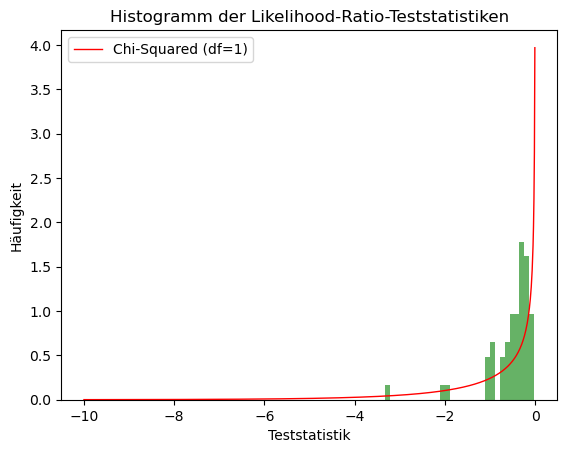

In [20]:
lrt_hist = []
for val in lrt_results:
    if val < 0:
        lrt_hist.append(val)


# Histogramm der Teststatistiken erstellen
plt.hist(np.array(torch.stack(lrt_hist).detach()), bins=30, density=True, alpha=0.6, color='g')# balken dünner und so dass man mit chi quadrat vergleichen kann

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
x = np.linspace(0, 10, 1000)
plt.plot(-x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()